10
20
20
31
Best weights saved on Epoch 03893
Model: "feed_back"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  13051     
_________________________________________________________________
dense_1 (Dense)              multiple                  32        
Total params: 13,083
Trainable params: 13,083
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: C:/Users/xt16846/OneDrive - University of Bristol/Documents/PhD/2021 summer project/repos/NARX_Train_py/down_sample2/NARX_nu20_nl20_out10\assets


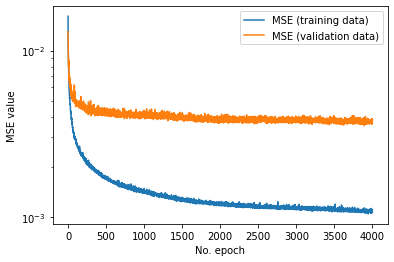

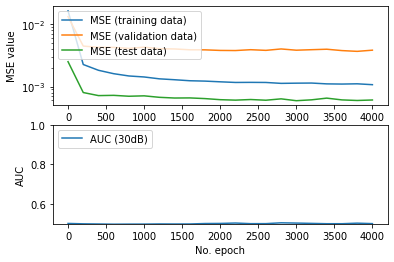

In [1]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.io
import statistics
import math

folder = 'C:/Users/xt16846/OneDrive - University of Bristol/Documents/PhD/2021 summer project/repos/NARX_Train_py/'
savefold = folder + 'down_sample2'

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

down_sample_factor=5

OUT_STEPS = 50//down_sample_factor  # number of points predicted ahead 

n_l = 2*OUT_STEPS 
n_u = 2*OUT_STEPS #int(200 - n_l)  
n_h = n_u + n_l
hidden_unit = math.ceil(math.sqrt((n_u+1)*n_l+1)+10)

print(OUT_STEPS)
print(n_u)
print(n_l)
print(hidden_unit)

val_size = 5
test_size = 220-val_size
batch_size = 256
tail = n_h+OUT_STEPS

initial_learning_rate = 1e-3
decay_rate = 0.99
max_epochs = 10001 
detect_test_every = 200 #int(max_epochs-1) #test detection every X epochs

def TestDetection(model):
    error_absolute_30db = np.zeros ((test_defect_30db.shape[1]//down_sample_factor, test_size)) 
    residual_absolute = np.zeros ((test_defect_30db.shape[1]//down_sample_factor, test_size))

    defect_signals_30db = test_defect_30db.flatten()
    defect_signals_30db = defect_signals_30db[3::down_sample_factor]
    df_signals = test_signals.flatten()
    df_signals = df_signals[3::down_sample_factor]

    test_len =len(defect_signals_30db)- n_h -OUT_STEPS+1

    x_defect_30db = np.zeros ((test_len, n_h))
    y_defect_30db = np.zeros ((test_len, 1))

    x_df = np.zeros ((test_len, n_h))
    y_df = np.zeros ((test_len, 1))

    for j in range(n_h):
    
        x_defect_30db[:,j] = defect_signals_30db[j:j+test_len]
        x_df[:,j] = df_signals[j:j+test_len]

    y_defect_30db[:,0] = defect_signals_30db[-test_len::]
    y_df[:,0] = df_signals[-test_len::]

    x_defect_30db = tf.convert_to_tensor(x_defect_30db, dtype=tf.float32)
    y_defect_30db = tf.convert_to_tensor(y_defect_30db, dtype=tf.float32)
    x_df = tf.convert_to_tensor(x_df, dtype=tf.float32)
    y_df = tf.convert_to_tensor(y_df, dtype=tf.float32)

    predicted_baseline_30db = model.predict(x_defect_30db)
    baseline_df = model.predict(x_df)

    df_residual = y_df - baseline_df
    df_residual = np.asarray(tf.squeeze(df_residual))
    df_residual = df_residual[-(test_size-1)*(test_defect_30db.shape[1]//down_sample_factor):]
    df_residual = df_residual - statistics.mean(df_residual)

    defect_error_30db = np.asarray(y_defect_30db) - predicted_baseline_30db
    defect_error_30db = np.asarray(tf.squeeze(defect_error_30db))
    defect_error_30db = defect_error_30db[-(test_size-1)*(test_defect_30db.shape[1]//down_sample_factor):]
    defect_error_30db = defect_error_30db - statistics.mean(defect_error_30db)

    for k in range(test_size-1):

        error_absolute_30db [:,k] = defect_error_30db[k*(test_defect_30db.shape[1]//down_sample_factor): (k+1)*(test_defect_30db.shape[1]//down_sample_factor)] 
        error_absolute_30db [:,k] = np.multiply(error_absolute_30db [:,k], scale[k])
        error_absolute_30db [:,k] = abs(error_absolute_30db [:,k])
    
        residual_absolute [:,k] = df_residual[k*(test_defect_30db.shape[1]//down_sample_factor): (k+1)*(test_defect_30db.shape[1]//down_sample_factor)] 
        residual_absolute [:,k] = np.multiply(residual_absolute [:,k], scale[k])
        residual_absolute [:,k] = abs(residual_absolute [:,k])

    square_error= np.square(residual_absolute).flatten()
    test_mse = np.mean(square_error, axis=0)

    error_absolute_30db = error_absolute_30db [-error_len:-5,:]
    residual_absolute = residual_absolute [-error_len:-5,:]
    
    max_residual = np.amax(residual_absolute, axis = 0)
    max_error_30db = np.amax(error_absolute_30db, axis = 0)
    
    scores_30db = np.concatenate((max_residual,max_error_30db))
    label1 = np.zeros((len(max_residual)))
    label2 = np.ones((len(max_error_30db)))
    label = np.concatenate((label1, label2))
    PFA_30db, POD_30db, thresholds_30db = roc_curve(label, scores_30db)

    roc_auc_30db = auc(PFA_30db, POD_30db)

    return [roc_auc_30db, test_mse]  
    
f1 = scipy.io.loadmat(folder +'train_normalised2.mat')
training_signals = np.array(f1['train_normalised'])
training_signals = np.transpose(training_signals)

f2 = scipy.io.loadmat(folder +'test_normalised.mat')
test_samples = np.array(f2['test_normalised'])
test_signals = test_samples[:test_size,:]

val_data = test_samples[ -val_size:, :]
val_data = val_data.flatten()
val_data = val_data[3::down_sample_factor] ##

training_samples = training_signals.flatten()
training_samples = training_samples[3::down_sample_factor] ##
train_len = len(training_samples) - n_h -OUT_STEPS+1
val_len = len(val_data)-n_h-OUT_STEPS+1
error_len = (test_signals.shape[1]//down_sample_factor)-tail ##

x_train = np.zeros ((train_len, n_h))
y_train = np.zeros ((train_len, 1))

for i in range(train_len):
    x_train[i,:] = training_samples[i:(i+n_h)]
    y_train[i,:] = training_samples[(i+n_h+OUT_STEPS-1)]

x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

x_val = np.zeros((val_len, n_h))
y_val = np.zeros((val_len,1))
for i in range(val_len):
    x_val[i,:] = val_data[i:(i+n_h)]
    y_val[i,:] = val_data[(i+n_h+OUT_STEPS-1)]

x_val = tf.convert_to_tensor(x_val, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

#Closed loop model

class FeedBack(tf.keras.Model):
    def __init__(self, hidden_units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.hidden_units = hidden_units

        self.hidden_layer = tf.keras.layers.Dense(hidden_units, activation='tanh')
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

model = FeedBack(hidden_units=hidden_unit, out_steps=OUT_STEPS)

def split(self, inputs):
    x = []
    for b in range(n_l):
        split_layer = tf.keras.layers.Lambda(lambda x: x[:,b:b+n_u+1])(inputs)
        x.append(split_layer)
    return x

FeedBack.split = split

def call(self, inputs, training=None):
    
    for n in range(self.out_steps):
        if n_l == 1:
            inp = inputs
        else:
            x = self.split(inputs)
            inp = tf.keras.layers.Concatenate(axis=-1)(x)
        hidden = self.hidden_layer(inp)
        output = self.output_layer(hidden)
        inputs = tf.concat((inputs[:,-n_h+1:],output),axis=1) #feed the output back to input
    return output

FeedBack.call = call

model.compile(loss=[tf.losses.MeanSquaredError()], 
              metrics=[tf.metrics.MeanAbsoluteError()], 
              optimizer=tf.optimizers.Adam(learning_rate=initial_learning_rate))
 
#Load Test Data

f7 = scipy.io.loadmat(folder +'test_defect_30db.mat')
test_defect_30db = np.array(f7['test_defect'])
test_defect_30db = test_defect_30db[:test_size,:]
f8 = scipy.io.loadmat(folder +'test_max.mat')
scale = np.array(f8['test_max'])
scale = scale[0,:test_size] # (1,215)

class AdditionalTests(tf.keras.callbacks.Callback):   #Create a callback
    def __init__(self, verbose=0, batch_size=None):
        super(AdditionalTests, self).__init__()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size
        self.lr = []

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)
        self.lr.append(self.model.optimizer.lr)

        # record the values currently in History (training and validation1)
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        if np.mod(epoch,detect_test_every) == 0:
            # evaluate on the additional validation sets
            AUC = TestDetection(self.model)
            for AUC1,valuename in zip(AUC,['auc_30db','test_mse']):
                self.history.setdefault(valuename, []).append(AUC1)
                           
class BestWeights(tf.keras.callbacks.Callback):

    def __init__(self,
               filepath,
               monitor='val_loss',
               min_delta=0,
               verbose=0,
               mode='auto',
               baseline=None):
        super(BestWeights, self).__init__()

        self.monitor = monitor
        self.verbose = verbose
        self.baseline = baseline
        self.min_delta = abs(min_delta)
        self.filepath = filepath
        self.best_weights = None
        self.best_epoch=0

        if mode not in ['auto', 'min', 'max']:
            logging.warning('BestWeights mode %s is unknown, '
                      'fallback to auto mode.', mode)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
        elif mode == 'max':
            self.monitor_op = np.greater
        else:
            if 'acc' in self.monitor:
                self.monitor_op = np.greater
            else:
                self.monitor_op = np.less

        if self.monitor_op == np.greater:
             self.min_delta *= 1
        else:
            self.min_delta *= -1

    def on_train_begin(self, logs=None):
    # Allow instances to be re-used
        self.best = np.Inf if self.monitor_op == np.less else -np.Inf
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        current = self.get_monitor_value(logs)
        if current is None:
            return

        if self._is_improvement(current, self.best):
            self.best = current
            self.best_weights = self.model.get_weights()
            self.best_epoch=epoch
            self.model.save_weights(self.filepath+'best_weights')
                      
    def on_train_end(self, logs=None):
        self.model.set_weights(self.best_weights)
        print('Best weights saved on Epoch %05d'%(self.best_epoch+1))

    def get_monitor_value(self, logs):
        logs = logs or {}
        monitor_value = logs.get(self.monitor)
        if monitor_value is None:
            logging.warning('BestWeights conditioned on metric `%s` '
                      'which is not available. Available metrics are: %s',
                      self.monitor, ','.join(list(logs.keys())))
        return monitor_value

    def _is_improvement(self, monitor_value, reference_value):
        return self.monitor_op(monitor_value - self.min_delta, reference_value)                

history = AdditionalTests()
save_best_weights=BestWeights(filepath=savefold, monitor='val_loss', mode='min')
model.fit(x_train, y_train, epochs=max_epochs, batch_size=batch_size,  validation_data=(x_val,y_val), callbacks=[history,save_best_weights], verbose=0)
model.summary()

model.save(savefold+'/NARX_nu'+f'{n_u}'+'_nl'+f'{n_l}'+'_out'+f'{OUT_STEPS}')
np.save(savefold+'/History_nu'+f'{n_u}'+'_nl'+f'{n_l}'+'_out'+f'{OUT_STEPS}',history.history)
results = TestDetection(model)
np.save(savefold+'/Results_nu'+f'{n_u}'+'_nl'+f'{n_l}'+'_out'+f'{OUT_STEPS}',results)

plt.figure()
plt.plot(history.history['loss'], label='MSE (training data)')
plt.plot(history.history['val_loss'], label='MSE (validation data)')
plt.yscale('log')
plt.legend(loc="upper right")
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.savefig(savefold+'/TrainGraph_nu'+f'{n_u}'+'_nl'+f'{n_l}'+'_out'+f'{OUT_STEPS}')

fig,(ax1,ax2) = plt.subplots(2,1)
ax1.plot(history.epoch[0::detect_test_every], history.history['loss'][0::detect_test_every], label='MSE (training data)')
ax1.plot(history.epoch[0::detect_test_every], history.history['val_loss'][0::detect_test_every], label='MSE (validation data)')
ax1.plot(history.epoch[0::detect_test_every], history.history['test_mse'], label='MSE (test data)')
ax2.plot(history.epoch[0::detect_test_every], history.history['auc_30db'], label='AUC (30dB)')
ax1.set_yscale('log')
ax1.set_ylabel('MSE value')
ax2.set_ylabel('AUC')
ax2.set_ylim([0.5, 1])
ax2.set_xlabel('No. epoch')
plt.legend(bbox_to_anchor=(1.6,0), loc="lower right")
plt.savefig(savefold+'/HistoryGraph_in'+f'{n_u}'+'_nl'+f'{n_l}'+'_out'+f'{OUT_STEPS}')

In [ ]:
train_add=10
val_size=5
test_size=220-val_size-train_add

f1 = scipy.io.loadmat(folder +'train_normalised2.mat')
training_signals = np.array(f1['train_normalised'])
training_signals = np.transpose(training_signals)

f2 = scipy.io.loadmat(folder +'test_normalised.mat')
test_samples = np.array(f2['test_normalised'])
test_signals = test_samples[:test_size,:]

val_data = test_samples[ (-val_size-train_add):, :]
val_data = val_data.flatten()
val_data = val_data[0::2] ##

training_additional = test_samples[-train_add:,:]
training_signals_more = np.concatenate([training_signals, training_additional])